In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
from jax import jit,grad,hessian,jacfwd,jacrev
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import InducedRKHS,OperatorModel,CholOperatorModel
from parabolic_data_utils import (
    build_burgers_data,build_tx_grid,
    build_tx_grid_chebyshev,setup_problem_data
)
from plotting import plot_input_data,plot_compare_error
from evaluation_metrics import compute_results    


  0%|          | 0/10099 [00:00<?, ?it/s]

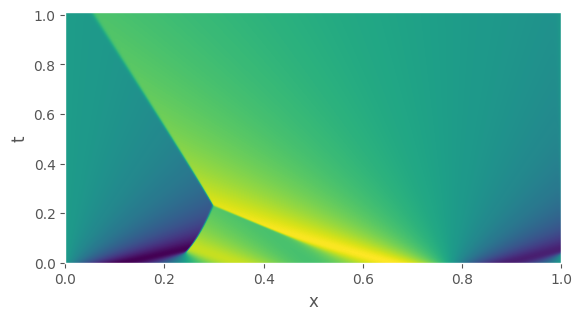

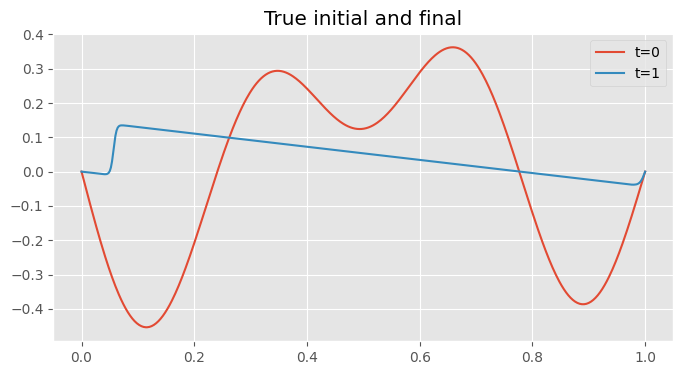

In [2]:
def func_u0(x):
    u0 = 0.25 * (x * np.sin(1 * np.pi*x) - np.sin(5*np.pi*x) - np.sin(3*np.pi*x))
    return u0


kappa = 0.001
alpha = 5.


u_true_function,ut_true_function,interpolant,t_vals,sols = (
    build_burgers_data(func_u0=func_u0,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
)

plt.imshow(sols[::-1],aspect = 0.5,extent = [0,1,t_vals[0],t_vals[-1]])
plt.xlabel("x")
plt.ylabel("t")
plt.grid(None)
plt.show()
plt.figure(figsize=(8,4))
num_fine_grid = 500
plt.title("True initial and final")
grid_points = jnp.linspace(0,1,num_fine_grid)
plt.plot(grid_points,u_true_function(jnp.vstack([0.0*jnp.ones(num_fine_grid),grid_points]).T),label = 't=0')
plt.plot(grid_points,u_true_function(jnp.vstack([1.*jnp.ones(num_fine_grid),grid_points]).T),label = 't=1')
plt.legend()
plt.show()

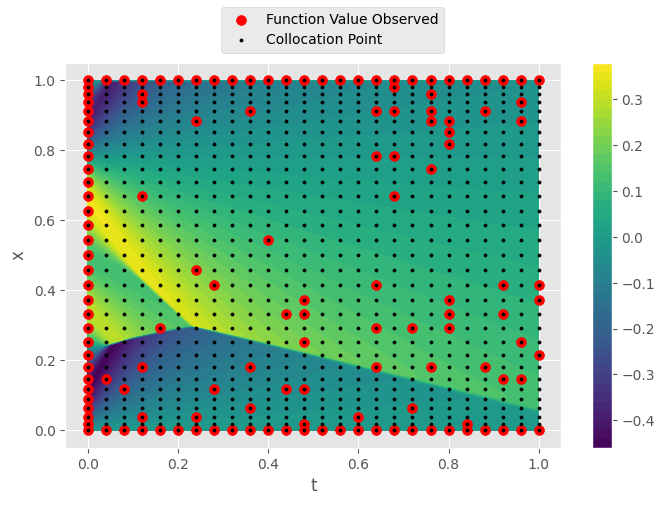

In [3]:
num_grid_x = 31
num_grid_t = 26
tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.5)


num_points = 40#old value
tx_all,tx_obs = setup_problem_data(
    tx_int,
    tx_bdy,
    60,
    jax.random.PRNGKey(55),
    times_to_observe = (0,)
)

u_true = u_true_function(tx_all)
u_obs = u_true_function(tx_obs)

num_fine_grid = 300
initial_time = 0
final_time = 1
t_fine,x_fine = jnp.meshgrid(jnp.linspace(initial_time,final_time,num_fine_grid),jnp.linspace(0,1,num_fine_grid))
tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T
plot_input_data(
    tx_obs,
    tx_all,
    u_true_function,
    tx_fine,
)

In [51]:
#Alternate lengthscale computation

# from Kernels import (
#     get_centered_scaled_poly_kernel,
#     get_anisotropic_gaussianRBF,
#     fit_kernel_params,
#     setup_matern,log1pexp,
#     get_rq_kernel
# )
# from functools import partial

# # base_kernel_family = setup_matern(5)
# # def param_kernel(x,y,params):
# #     lengthscales = log1pexp(params)
# #     rootD = jnp.diag(jnp.sqrt(lengthscales))
# #     return base_kernel_family(1.)(rootD@x,rootD@y)


# base_kernel_family = get_rq_kernel(1.)
# def param_kernel(x,y,params):
#     lengthscales = log1pexp(params)
#     rootD = jnp.diag(jnp.sqrt(lengthscales))
#     return base_kernel_family(rootD@x,rootD@y)

# fitted_params = fit_kernel_params(param_kernel,tx_obs,u_obs,2*jnp.ones(2))
# ML_inv_lengthscales = log1pexp(fitted_params)


# print(1/(ML_inv_lengthscales))

# #k_u = partial(param_kernel,params = fitted_params + 2.)

# def k_u(x,y):
#     inv_lengthscales = log1pexp(fitted_params)
#     rootD = jnp.diag(jnp.sqrt(inv_lengthscales))
#     return base_kernel_family(rootD@x,rootD@y)


In [4]:
# from EquationModel import CholInducedRKHS, CholOperatorModel, OperatorPDEModel
# from functools import partial

# u_operators = (eval_k,dx_k,dt_k)
# feature_operators = (eval_k,dx_k,dxx_k)

from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params
)
from EquationModel import CholInducedRKHS, CholOperatorModel, OperatorPDEModel
from functools import partial


u_operators = (eval_k,)
feature_operators = (eval_k,dx_k,dxx_k)

from Kernels import log1pexp,inv_log1pexp

def param_ani_gaussian_RBF(x,y,params):
    lengthscales = log1pexp(params)
    return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)

fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,tx_obs,u_obs,jnp.zeros(2))
ML_lengthscales = log1pexp(fitted_params)

k_u = get_anisotropic_gaussianRBF(1.,jnp.diag(log1pexp(fitted_params)))
print(1/(jnp.sqrt(ML_lengthscales)))

u_model = CholInducedRKHS(
    tx_all,
    u_operators,
    k_u,
    nugget_size = 1e-8
    )

u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_int,u_params_init))
    .reshape(
            len(tx_int),
            len(feature_operators),
            order = 'F'
        )
)

k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')

@vectorize_kfunc
def k_P(x,y):
    return k_P_u_part(x[2:],y[2:])

P_model = OperatorModel(k_P)    
    

EqnModel = OperatorPDEModel(
    P_model,
    (u_model,),
    (tx_obs,),
    (u_obs,),
    (tx_int,),
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 200
)

[0.18532609 0.12524221]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.3798, Jres = 33.51, alpha = 0.08333, improvement_ratio = 0.9973
Iteration 1, loss = 0.1736, Jres = 19.26, alpha = 0.06944, improvement_ratio = 1.003
Iteration 2, loss = 0.1131, Jres = 8.542, alpha = 0.05787, improvement_ratio = 0.9973
Iteration 3, loss = 0.08312, Jres = 3.009, alpha = 0.04823, improvement_ratio = 0.9995
Iteration 4, loss = 0.06483, Jres = 1.65, alpha = 0.04019, improvement_ratio = 1.003
Iteration 5, loss = 0.05259, Jres = 1.398, alpha = 0.03349, improvement_ratio = 1.004
Iteration 100, loss = 0.009239, Jres = 0.004757, alpha = 3.293e-06, improvement_ratio = 0.8829
Iteration 200, loss = 0.008541, Jres = 0.007805, alpha = 3.484e-06, improvement_ratio = 0.68
Iteration 300, loss = 0.00826, Jres = 0.01553, alpha = 1e-06, improvement_ratio = 0.3481
Iteration 400, loss = 0.008117, Jres = 0.008754, alpha = 1e-06, improvement_ratio = 0.4731
Iteration 500, loss = 0.008015, Jres = 0.005627, alpha = 1e-06, improvement_ratio = 0.5877


  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 0.00801335885250572
Converged


/tmp/ipykernel_3301030/114788580.py:18: DeprecationWarning: hstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  plt.plot(jnp.hstack([convergence_data['loss_vals'],refine_convergence_data['loss_vals']]))


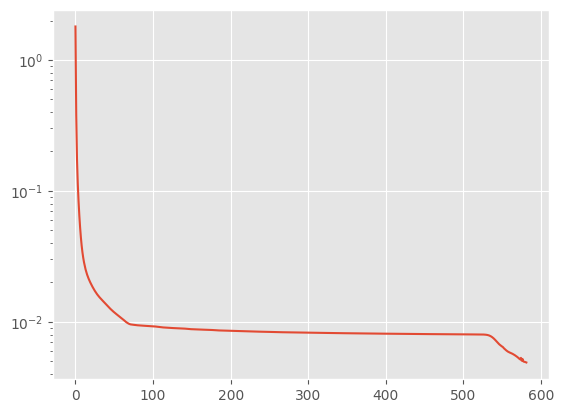

In [5]:
import Optimizers
import importlib
importlib.reload(Optimizers)
from Optimizers import CholeskyLM,SVD_LM

params_init = jnp.hstack([u_params_init,jnp.zeros(len(grid_features_init))])

params,convergence_data = CholeskyLM(
    params_init.copy(),
    EqnModel,
    beta = 1e-11,
    max_iter = 501,
    init_alpha=0.1,
    line_search_increase_ratio=1.4,
    print_every = 100
)
p_adjusted,refine_convergence_data = SVD_LM(params,EqnModel,1e-3,500)
plt.plot(jnp.hstack([convergence_data['loss_vals'],refine_convergence_data['loss_vals']]))
plt.yscale('log')
plt.show()

Pre Refinement PDE MSE 0.010944387225161287
Post Refinement PDE MSE 0.0065959898972701705


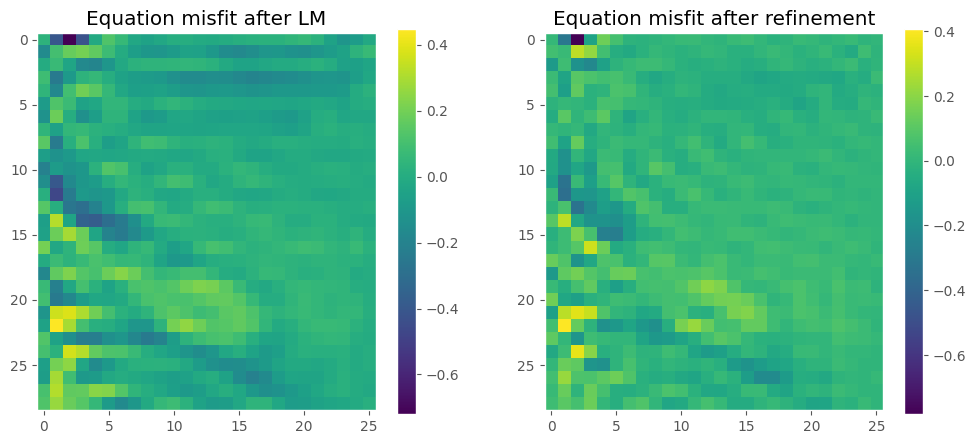

In [6]:
equation_residuals = EqnModel.equation_residual(params)
equation_residuals_refined = EqnModel.equation_residual(p_adjusted)

print("Pre Refinement PDE MSE",jnp.mean(equation_residuals**2))
print("Post Refinement PDE MSE",jnp.mean(equation_residuals_refined**2))
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Equation misfit after LM")
plt.imshow(equation_residuals.reshape(num_grid_x-2,num_grid_t)[::-1])
plt.grid(None)
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Equation misfit after refinement")
plt.imshow(equation_residuals_refined.reshape(num_grid_x-2,num_grid_t)[::-1])
plt.grid(None)
plt.colorbar()
plt.show()


,NRMSE,NMAE
1 Step,0.385029,0.182886
2 Step,1.415064,1.075873


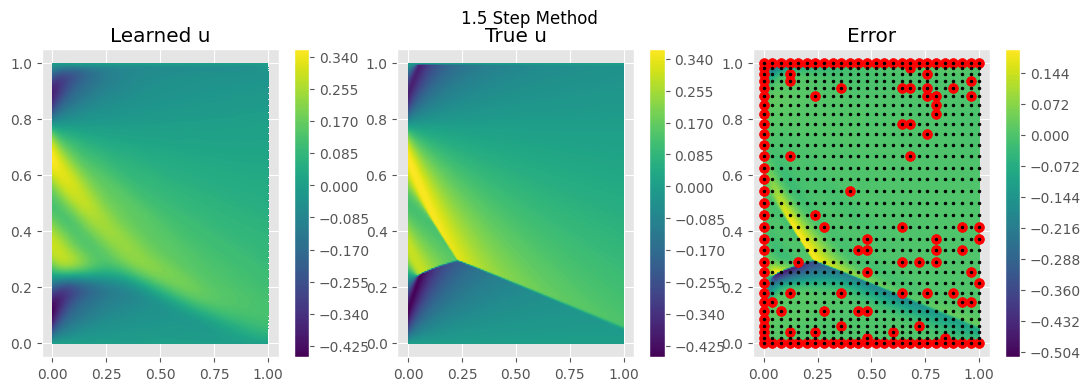

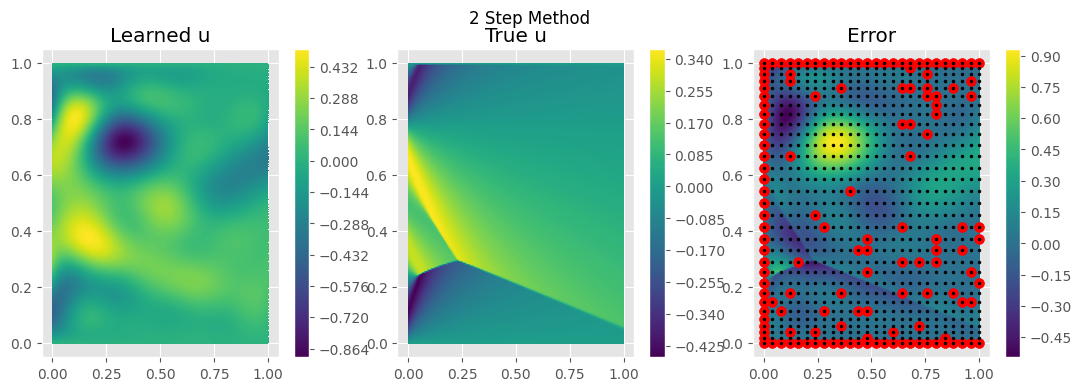

In [8]:
from evaluation_metrics import get_nrmse,get_nmae,compute_results

u_sol = p_adjusted[:u_model.num_params]
P_sol = p_adjusted[u_model.num_params:]

# u_sol = params[:u_model.num_params]
# P_sol = params[u_model.num_params:]


num_fine_grid = 200
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


u_eval_fine =u_model.point_evaluate(tx_grid_fine,u_sol)
u_true_fine = u_true_function(tx_grid_fine)

display(compute_results(
    u_true_fine,
    {
        "1 Step":u_eval_fine,
        "2 Step":u_model.point_evaluate(tx_grid_fine,u_params_init),
    },
    {"NRMSE":get_nrmse,"NMAE":get_nmae}
))

plot_compare_error(
    tx_grid_fine,tx_all,tx_obs,lambda x:u_model.point_evaluate(x,u_sol),u_true_function,title= "1.5 Step Method"
)

plot_compare_error(
    tx_grid_fine,tx_all,tx_obs,lambda x:u_model.point_evaluate(x,u_params_init),u_true_function,title = "2 Step Method"
)

In [10]:
num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
tx_fine_int = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


# grad_u_true = jax.vmap(grad(u_single))(tx_fine_int)
# hess_u_true = jax.vmap(hessian(u_single))(tx_fine_int)

u_true_interior = u_true_function(tx_fine_int)
ut_true = interpolant.partial_derivative(1,0)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)
ux_true = interpolant.partial_derivative(0,1)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)
uxx_true = interpolant.partial_derivative(0,2)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)


true_features = jnp.vstack([u_true_interior,ux_true,uxx_true]).T
true_features = jnp.hstack([tx_fine_int,true_features])

model_grid_features = EqnModel.get_stacked_eqn_features((u_sol,))
model_features = EqnModel.get_single_eqn_features(u_model,u_sol,tx_fine_int)
#model_features = u_model.evaluate_operators(feature_operators,tx_fine_int,u_sol).reshape(len(tx_fine_int),len(feature_operators),order = 'F')

preds_ut_model_features = P_model.kernel_function(model_features,model_grid_features)@P_sol
preds_ut_true_features = P_model.kernel_function(true_features,model_grid_features)@P_sol

init_P_features = EqnModel.get_stacked_eqn_features((u_params_init,))

K = P_model.kernel_function(init_P_features,init_P_features)

P_params_naive = jnp.linalg.solve(K+1e-8*diagpart(K),EqnModel.get_stacked_rhs_op((u_params_init,)))

init_P_features_fine = EqnModel.get_single_eqn_features(u_model,u_params_init,tx_fine_int)
P_preds_init_model_features_init = P_model.kernel_function(init_P_features_fine,init_P_features)@P_params_naive

P_preds_init_model_features = P_model.kernel_function(model_features,init_P_features)@P_params_naive
P_preds_init_true_features = P_model.kernel_function(true_features,init_P_features)@P_params_naive

compute_results(
    ut_true,
    {
        "1.5 Step Model Features":preds_ut_model_features,
        "1.5 Step True Features":preds_ut_true_features,
        "2 Step Model Features": P_preds_init_model_features_init,
        "2 Step True Features":P_preds_init_true_features,
    },
    {"NRMSE":get_nrmse,"NMAE":get_nmae}
)

,NRMSE,NMAE
1.5 Step Model Features,0.941222,0.697883
1.5 Step True Features,34247.594107,2199.044365
2 Step Model Features,1.128302,1.515270
2 Step True Features,20805.117880,1337.837742


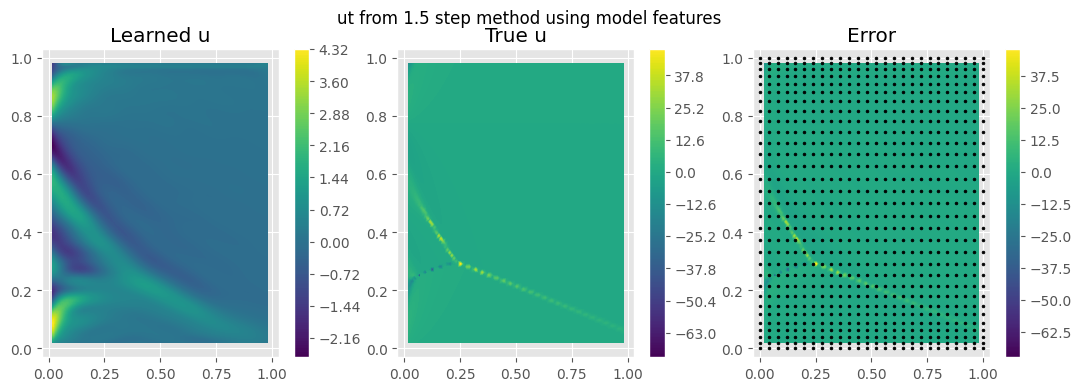

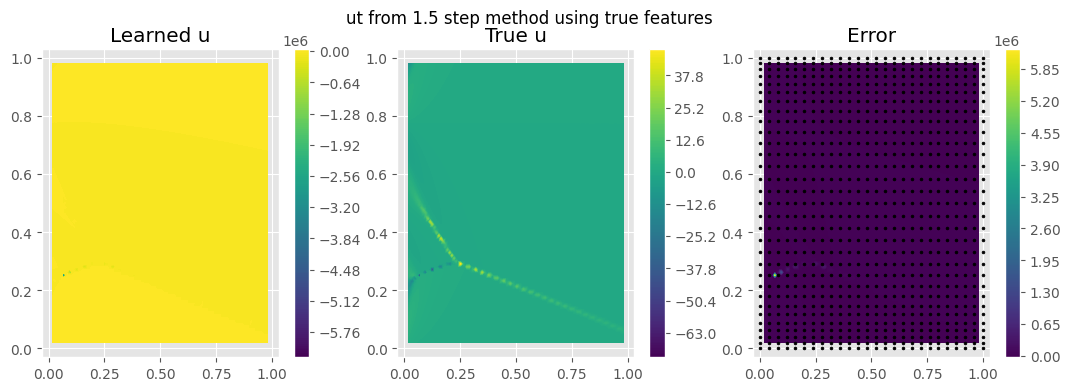

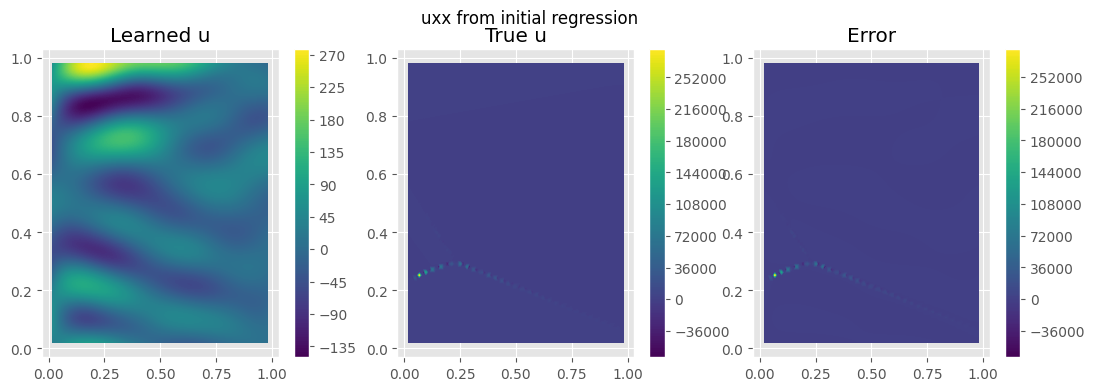

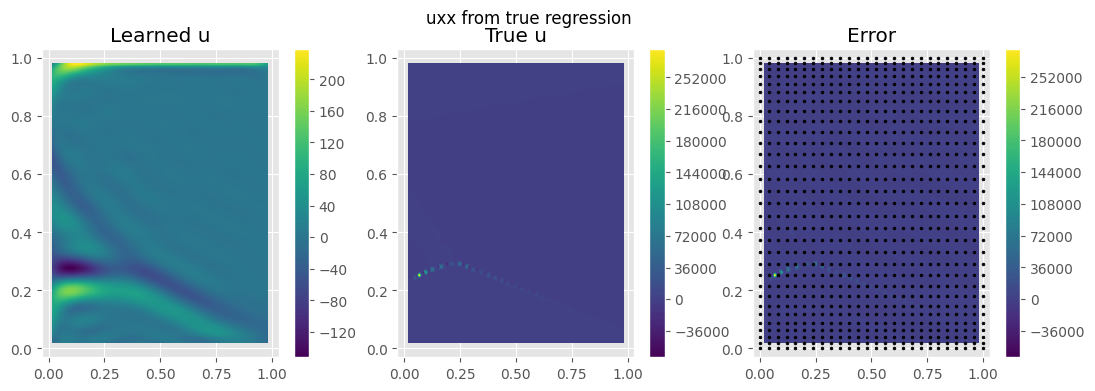

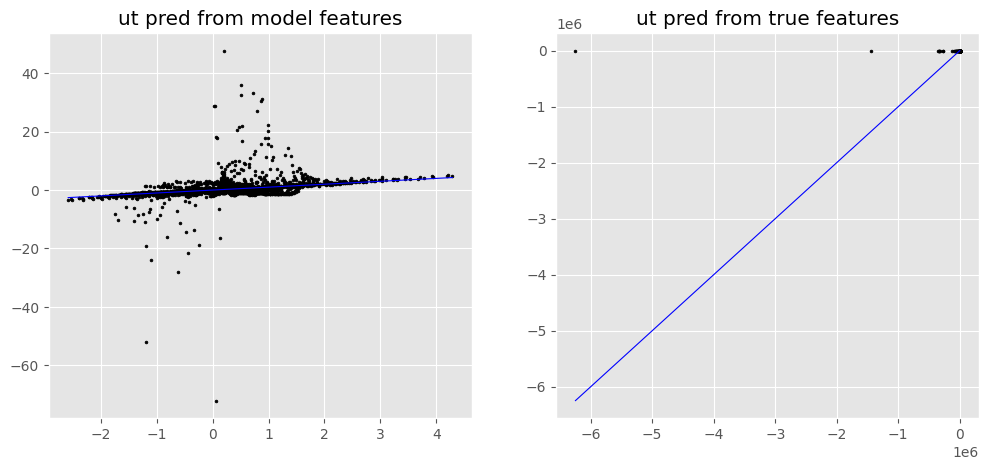

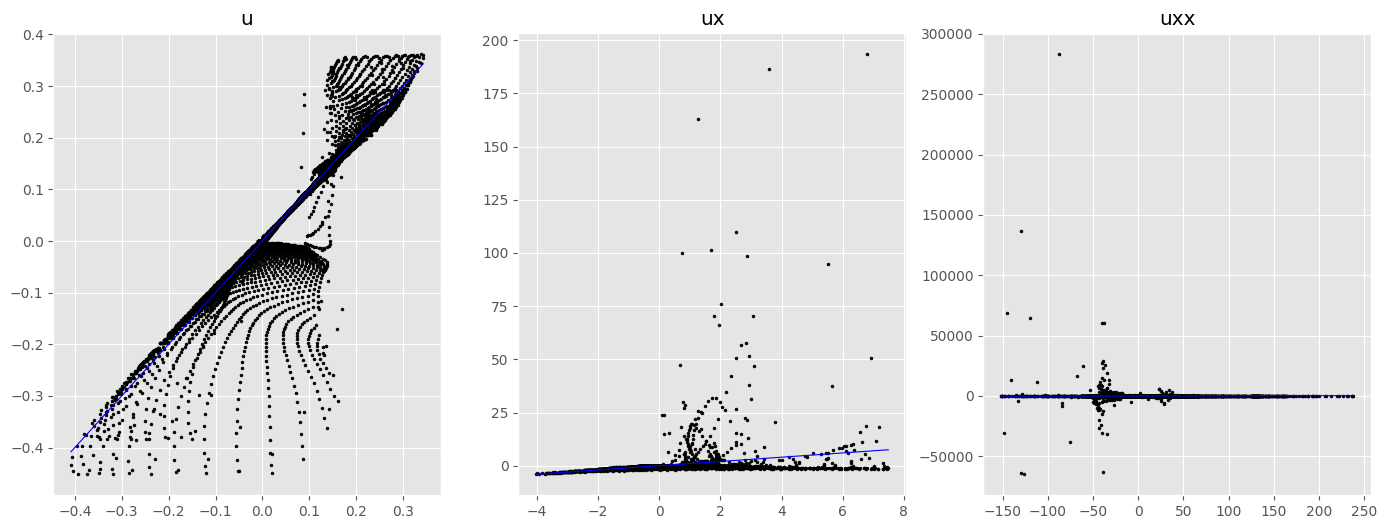

In [11]:
from plotting import compare_values,plot_compare_error_values

plot_compare_error_values(
    tx_fine_int,tx_all,None,preds_ut_model_features,ut_true,title = "ut from 1.5 step method using model features"
)

plot_compare_error_values(
    tx_fine_int,tx_all,None,preds_ut_true_features,ut_true,title = "ut from 1.5 step method using true features"
)

plot_compare_error_values(
    tx_fine_int,None,None,init_P_features_fine[:,4],uxx_true,title = "uxx from initial regression"
)

plot_compare_error_values(
    tx_fine_int,tx_all,None,model_features[:,4],uxx_true,title = "uxx from true regression"
)

plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.title('ut pred from model features')
compare_values(preds_ut_model_features,ut_true)
plt.subplot(1,2,2)
plt.title('ut pred from true features')
compare_values(preds_ut_true_features,ut_true)
plt.show()

plt.figure(figsize= (17,6))
plt.subplot(1,3,1)
plt.title('u')
compare_values(model_features[:,2],true_features[:,2])
plt.subplot(1,3,2)
plt.title('ux')
compare_values(model_features[:,3],true_features[:,3])
plt.subplot(1,3,3)
plt.title("uxx")
compare_values(model_features[:,4],true_features[:,4])
plt.show()


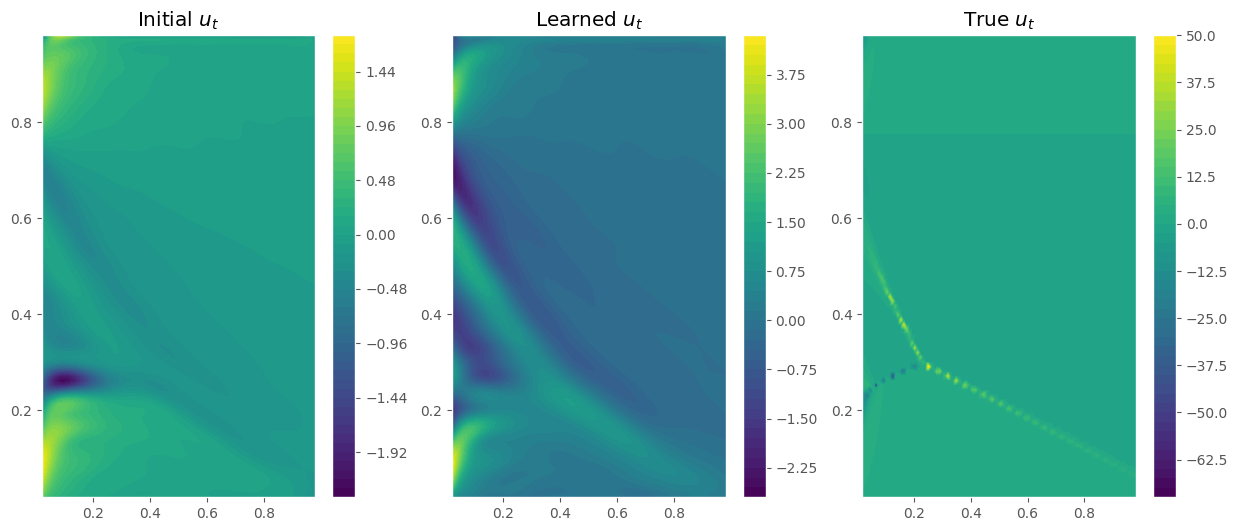

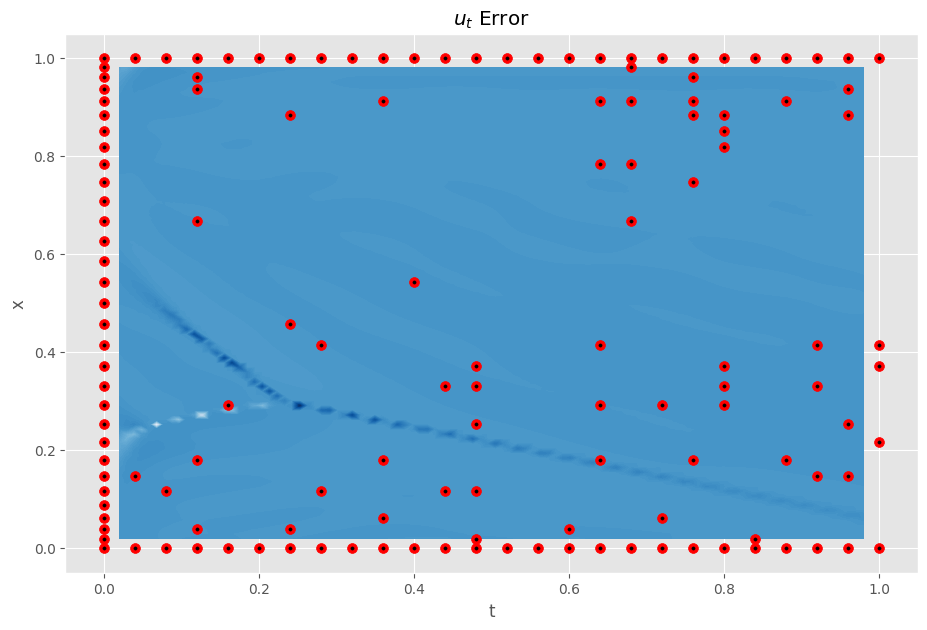

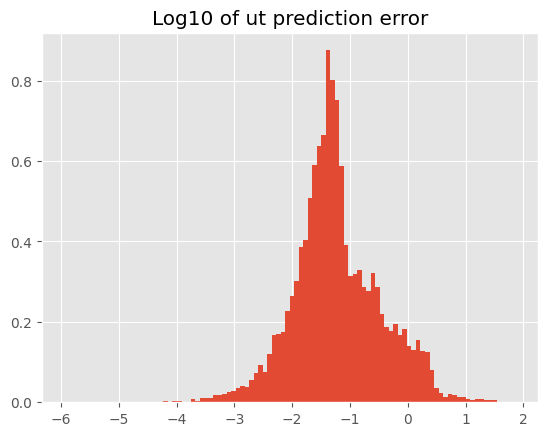

In [12]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)

plt.title("Initial $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],P_preds_init_model_features,50)
plt.colorbar()

plt.subplot(1,3,2)
plt.title("Learned $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],preds_ut_model_features,50,)
plt.colorbar()

plt.subplot(1,3,3)
plt.title("True $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true,50)
plt.colorbar()

plt.show()
plt.figure(figsize=(11,7))
plt.title("$u_t$ Error")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true-preds_ut_model_features,100,cmap = 'Blues')
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red',s = 50,label = 'Given value of u(t,x)')
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='black',s = 5,label = 'Given value of u(t,x)')

#plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 4)
plt.xlabel("t")
plt.ylabel("x")
plt.show()
plt.title("Log10 of ut prediction error")
plt.hist(jnp.log10(jnp.abs(ut_true-preds_ut_model_features) + 1e-20),100,density = True)
plt.show()

  0%|          | 0/10099 [00:00<?, ?it/s]

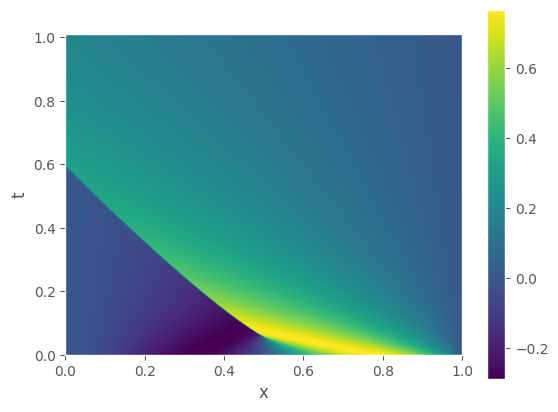

In [13]:
def new_func_u0(x):
    u0 = -1 * x * np.sin(2 * jnp.pi * x)
    return u0

new_u_true_function,new_ut_true_function,new_interp,t_vals,sols_new = (
    build_burgers_data(func_u0=new_func_u0,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
)

plt.imshow(sols_new[::-1],aspect = 0.8,extent = [0,1,t_vals[0],t_vals[-1]])
plt.xlabel("x")
plt.ylabel("t")
plt.grid(None)
plt.colorbar()
plt.show()

In [14]:
@jit
def get_pred_ut(input_features):
    return P_model.kernel_function(input_features,model_grid_features)@P_sol
tx_init_bdy = jnp.vstack([tx_int[tx_int[:,0]==0],tx_bdy])

new_obs = new_u_true_function(tx_init_bdy)


class PdeModel():
    datafit_weight = 50.
    @jit
    def get_grid_features(u_params):
        evaluation = u_model.evaluate_operators(feature_operators,tx_int,u_params)
        grid_features = evaluation.reshape(len(tx_int),len(feature_operators),order = 'F')
        return jnp.hstack([tx_int,grid_features])
    
    @jit
    def get_grid_target(u_params):
        return u_model.evaluate_operators((dt_k,),tx_int,u_params)
    
    @jit
    def eval_obs_points(u_params):
        return u_model.point_evaluate(tx_init_bdy,u_params)
    
    @jit
    def datafit_residual(u_params):
        obs_preds = PdeModel.eval_obs_points(u_params)
        return new_obs - obs_preds
    
    @jit
    def equation_residual(u_params):
        P_features = PdeModel.get_grid_features(u_params)
        P_model_preds = get_pred_ut(P_features)
        ugrid_target = PdeModel.get_grid_target(u_params)
        return (ugrid_target - P_model_preds)
    
    @jit
    def F(u_params):
        eqn_res = PdeModel.equation_residual(u_params)
        data_res = PdeModel.datafit_residual(u_params)
        return jnp.hstack([
            PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
            eqn_res/jnp.sqrt(len(eqn_res))
            ])
    
    jac = jit(jacrev(F))

    def loss(u_params):
        return jnp.linalg.norm(PdeModel.F(u_params))**2
    
    @jit
    def damping_matrix(u_params):
        return u_model.kmat+1e-5 * diagpart(u_model.kmat)

In [15]:
new_u_init = 0*u_sol

u_params_pde,pde_convergence_data = CholeskyLM(
    new_u_init.copy(),
    PdeModel,
    beta = 0.,
    max_iter = 101,
    init_alpha=0.05,
    line_search_increase_ratio=1.4,
    print_every = 10
)
u_pde_adj,pde_refine_conv_data = SVD_LM(u_params_pde,PdeModel,1e-1,150)


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.8224, Jres = 172.8, alpha = 0.04167, improvement_ratio = 0.9883
Iteration 1, loss = 0.3775, Jres = 4.557, alpha = 0.04167, improvement_ratio = 0.6088
Iteration 2, loss = 0.123, Jres = 2.379, alpha = 0.03472, improvement_ratio = 0.9482
Iteration 3, loss = 0.1125, Jres = 0.1774, alpha = 0.02894, improvement_ratio = 1.059
Iteration 4, loss = 0.1085, Jres = 0.03309, alpha = 0.02411, improvement_ratio = 1.177
Iteration 5, loss = 0.1058, Jres = 0.02117, alpha = 0.02009, improvement_ratio = 1.192
Iteration 10, loss = 0.09831, Jres = 0.01535, alpha = 0.008075, improvement_ratio = 1.14
Iteration 20, loss = 0.0921, Jres = 0.006965, alpha = 0.001304, improvement_ratio = 1.075
Iteration 30, loss = 0.08808, Jres = 0.004056, alpha = 0.0002106, improvement_ratio = 1.03
Iteration 40, loss = 0.08492, Jres = 0.0007142, alpha = 3.402e-05, improvement_ratio = 1.002
Iteration 50, loss = 0.08055, Jres = 0.004361, alpha = 5.494e-06, improvement_ratio = 1.021
Iteration 60, loss = 0.07678

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.14565021954761592
Converged


Sup norm error:  0.7722670822818433
NRMSE  0.5801002749494498


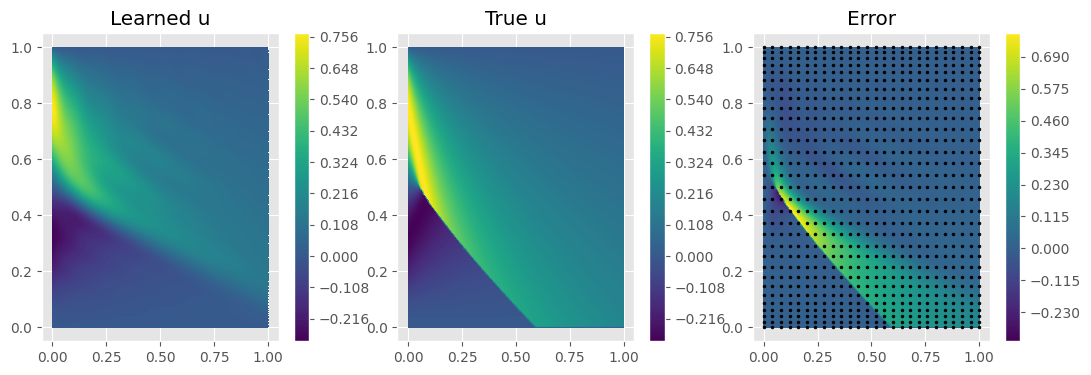

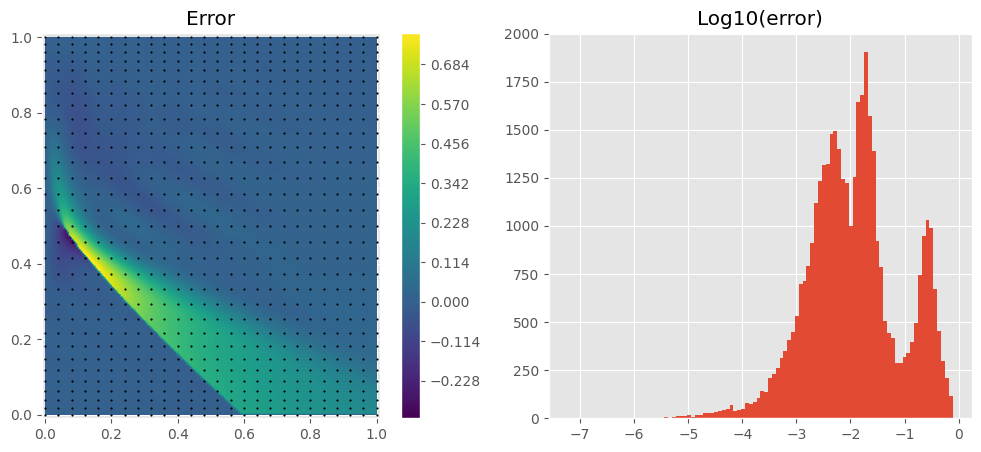

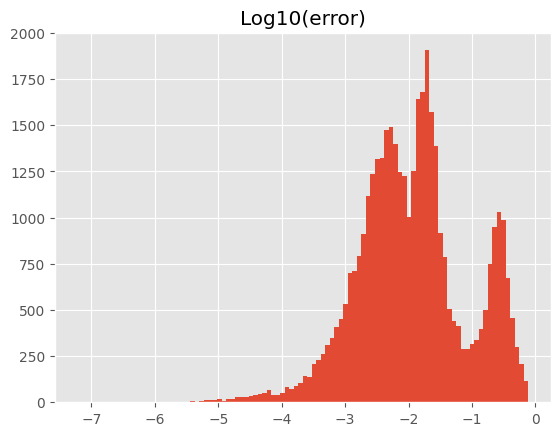

In [16]:
from plotting import plot_compare_error
new_u_eval_fine = u_model.point_evaluate(tx_grid_fine,u_pde_adj)
new_u_true_fine = new_u_true_function(tx_grid_fine)

print("Sup norm error: ",jnp.max(jnp.abs(new_u_true_fine-new_u_eval_fine)))
print("NRMSE ",get_nrmse(new_u_true_fine,new_u_eval_fine))

plot_compare_error(
    tx_grid_fine,
    tx_all,
    None,
    lambda x:u_model.point_evaluate(x,u_pde_adj),
    new_u_true_function
)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],new_u_true_fine-new_u_eval_fine,200)
plt.colorbar()
plt.scatter(tx_all[:,0],tx_all[:,1],s = 1,c='black')
plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
plt.title("Error")
plt.subplot(1,2,2)
plt.title("Log10(error)")
plt.hist(jnp.log10(jnp.abs(new_u_true_fine-new_u_eval_fine)),100)
plt.show()

plt.title("Log10(error)")
plt.hist(jnp.log10(jnp.abs(new_u_true_fine-new_u_eval_fine)),100)
plt.show()

### Operator learning error

We are learning the PDE from the problem
$$
\begin{align*}
\text{PDE: } u_t &= uu_x + u_{xx} u \text{ for } x\in[0,1] \text{ and } t \in [0,1] \\
\text{BC: } u(t,x) &= 0 \text{ for } x\in \{0,1\} \text{ and } t \in [0,1] \\
\text{IC: } u(0,x) &= u^0(x) \text{ for } x\in [0,1] \\
\end{align*}
$$

The data given is of the form
$$
\{Y,u_i(Y)\}_{i=1}^1
$$

$$
\begin{align*}
\text{True operator: } P(u) &= u_t(t,x) \\ 
\text{Learned operator: } \hat P(u)
\end{align*}
$$

#### Action plan

1. Get multiple pairs of observations

$$
\{Y,u_m(Y)\}_{m=1}^M
$$

from solving $M$ Burgers' equations with initial conditions sampled from $u_{\text{train}}^0 \sim \mathcal{GP}(\text{pinned})$. Are we learning the t-derivative operator then ?

2. Using the training data write the code for multiple pairs of functions for Burgers to learn
$$
\hat P
$$

3. We would like to test how good is the learned $\hat P$ in the following way:

 - Sample $u_{\text{new}}^0 \sim \mathcal{GP}(\text{pinned})$. Get 

> $u_{\text{new}}$: True solution of PDE.

> $\hat u_{\text{new}}$: Predicted solution by solving $\hat P(u) = R(u,u_x,u_{xx})$.

- Compare $u_{\text{new}}$ vs. $\hat u_{\text{new}}$.

- Start with big viscocity, to reduce the number of points needed.
- Reduce viscocity slowly after.